# Importing the Dataset and Packages

The powershell in the assosiated GitHub repository allows for this notebook to download the datasetfor this project, provided you complete the ".env" file with your kaggle API key, and file path.

This script was written, so that this notebook may be run, tested, and modified either in the kaggle environment, or on a configured windows machine.

In [92]:
import re
import warnings
import math
import dotenv
import kagglehub
import os
import subprocess
import ipywidgets


import sklearn_pandas as sk
import pandas as pd
import tensorflow as tf
import keras as ks
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from scipy.stats import anderson, lognorm, probplot, shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


try:
    dotenv.load_dotenv()
except:
    print("--Dotenv not loaded--")


# Check for Kaggle environment and set the file path
if os.path.exists("/kaggle/input/churn-modelling/Churn_Modelling.csv"):
    # Kaggle
    file_path = "/kaggle/input/churn-modelling/Churn_Modelling.csv"
else:
    # Local
    file_path = (str((os.getenv("LOCAL_FILE_LOCATION"))))

# Load Dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully!")
except FileNotFoundError:
    print(f"Error: File not found at : file_path")
    try:
        print("Attempting to run download_data_ps1")
        path = os.getenv("SCRIPT_PATH")
        subprocess.run(["powershell", "-ExecutionPolicy", "Bypass", "-File", path],
                       check = True, capture_output =  True, text = True)
        print("Powershell Download Script Run Successfully. Now attempting to reload dataset...")
        df = pd.read_csv(file_path)
        if df is not None and not df.empty:
            print("Dataset Loaded Successfully")
        else:
            print("Data not loaded")
    except Exception as e:
        print(f"Error running powershell script: {e}")
        df = None

# Display the first few rows of the dataset
if df is not None:
    display(df.head())

Dataset Loaded Successfully!


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Cleaning Dataset

The target variable is the last variable in this dataset. It is called "Exited". It is binary, where a 1 represents a customer closing thier account, and a 0 represents a retained customer.

Let's preview the data in order to understand what we have to work with.

First, I will drop the insignificant variables, which are the "RowNumber", "CustomerId", and "Surname" variables. They are arbitrary, and not useful for our algorithm.

In [93]:
RANDOM = 379

X = df.iloc[:, 3:-1]
Y = df.iloc[:,-1:]

display(X.head())
display(Y.head())

display(f"{X.shape=}")
display(f"{Y.shape=}")

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


,Exited
0,1
1,0
2,1
3,0
4,0


'X.shape=(10000, 10)'

'Y.shape=(10000, 1)'

As you can see, we have 10,000 observations for both the predictor and target variables.

Now, we will check the dataset for any Null values and duplicates.

In [94]:
new_df = X.copy()
new_df['Exited'] = Y

print(df.isna().sum(), '\n')
print(f"Duplicate Count   ", df.duplicated().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64 

Duplicate Count    0


In [95]:
pattern = r'\?'
null_df = df["Surname"].astype(str).str.contains(pattern)
mark_count = 0
for val in null_df: 
    if val : mark_count += 1
display(f"The number of question marks appearing in the surname column is : {mark_count}.")

'The number of question marks appearing in the surname column is : 92.'

In the "Surname" column, there are rare instances of "?" appearing. This indicates that there is missing or incomplete names. This is not concerning, because the "Surname" variable will be discarded when we build our model. 

Since there are no concerning NA values or duplicates, we can proceed with encoding.

# Exploratory Data Analysis

In this section, I will try to get a basic idea of what this dataset looks like.

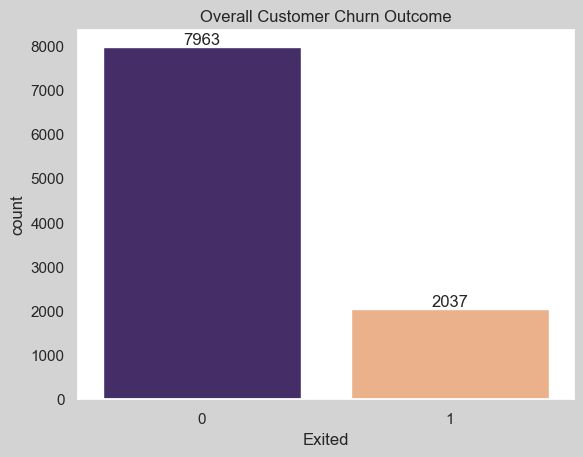

In [96]:
sb.set_theme(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgray'})
colors = ['#432371',"#FAAE7B", '#D4314C', '#5E0303', '#504AEC']

chart = sb.countplot(x = df["Exited"], hue = df["Exited"], palette=colors[0:2], legend=False, data = df);
chart.set_title("Overall Customer Churn Outcome")
for container in chart.containers:
    chart.bar_label(container)

A total of 7,963 customers were retained, and 2,037 customers churned.

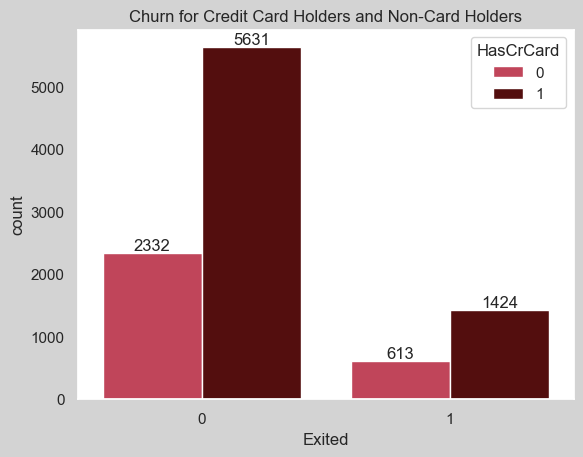

In [97]:
chart = sb.countplot(x = df["Exited"], hue = df["HasCrCard"], palette=colors[2:4]);
chart.set_title("Churn for Credit Card Holders and Non-Card Holders")
for container in chart.containers:
    chart.bar_label(container)

The majority of the people have credit cards, whether they churn or not.

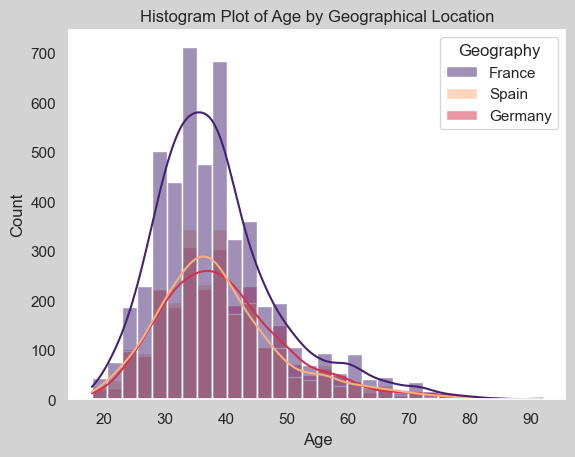

Mean Age   :  38.9
Median Age :  37.0


In [98]:
chart = sb.histplot(x = df['Age'], hue=df["Geography"], kde = True, bins = 30, palette = colors[0:3]);
chart.set_title("Histogram Plot of Age by Geographical Location")
plt.show()

print(f"Mean Age   : ", round(df["Age"].mean(),   1))
print(f"Median Age : ", round(df["Age"].median(), 1))

Over half of the observations are french, and the average age is 38.9. The median age is 37.0. The mean vs median, combined with visually inspecting the plot above indicates that the 'Age' variable has a skew to the right.

The sharp cutoff around 20 shows that the dataset does not include younger individuals, which could be explained by the bank having a minimum age requirement.

In [99]:
max_age = df["Age"].max()
min_age = df["Age"].min()

print(f"Maximum Age  : {max_age}")
print(f"Minimum Age  : {min_age}")
print(f"Range of Age : {max_age-min_age}")

Maximum Age  : 92
Minimum Age  : 18
Range of Age : 74


The right skew in Age is explained by the bank not allowing customers younger than 18 to bank with them. The skew occurs because the customers in the upper age range are fewer in number, yet still exist, as opposed to the lower age range (0-17) where these people are not allowed to be customers.

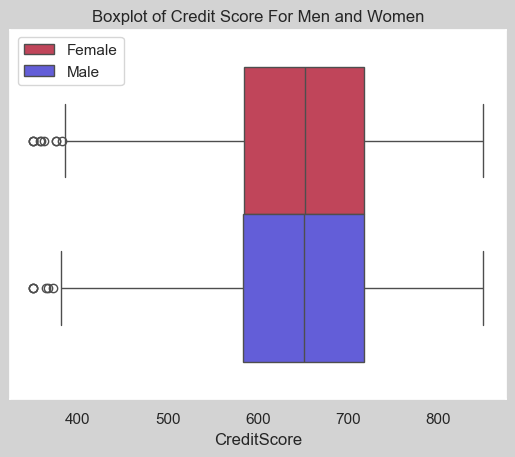

Mean Credit Score : 650.53


In [100]:
chart = sb.boxplot(x = df["CreditScore"], hue = df["Gender"], palette=(colors[2], colors[4]))
chart.legend(loc="upper left")
chart.set_title("Boxplot of Credit Score For Men and Women")
plt.show()

mean_cr_score = df["CreditScore"].mean()
print(f"Mean Credit Score : {round(mean_cr_score, 2)}")

The mean credit score for both men and women is nearly the same. Some outliers stretch out to the left and below 400.

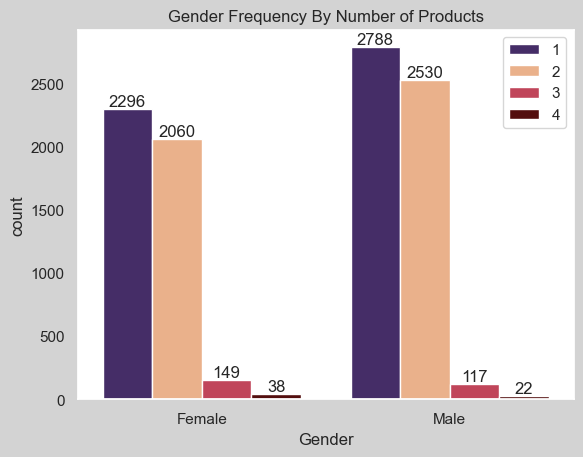

In [101]:
chart = sb.countplot(x = df["Gender"], hue = df["NumOfProducts"], palette=colors[0:4])
chart.set_title("Gender Frequency By Number of Products")
legend = chart.legend(loc = 'upper right')
legend.set_title(None)
for container in chart.containers:
    chart.bar_label(container)
plt.show()

The number of men and women in this dataset is almost even, with more men than women. Very few customers, regardless of gender, have more than 2 products. 

# Model Selection

### Distribution Analysis


First, we will examine the distributions of several variables in the dataset.

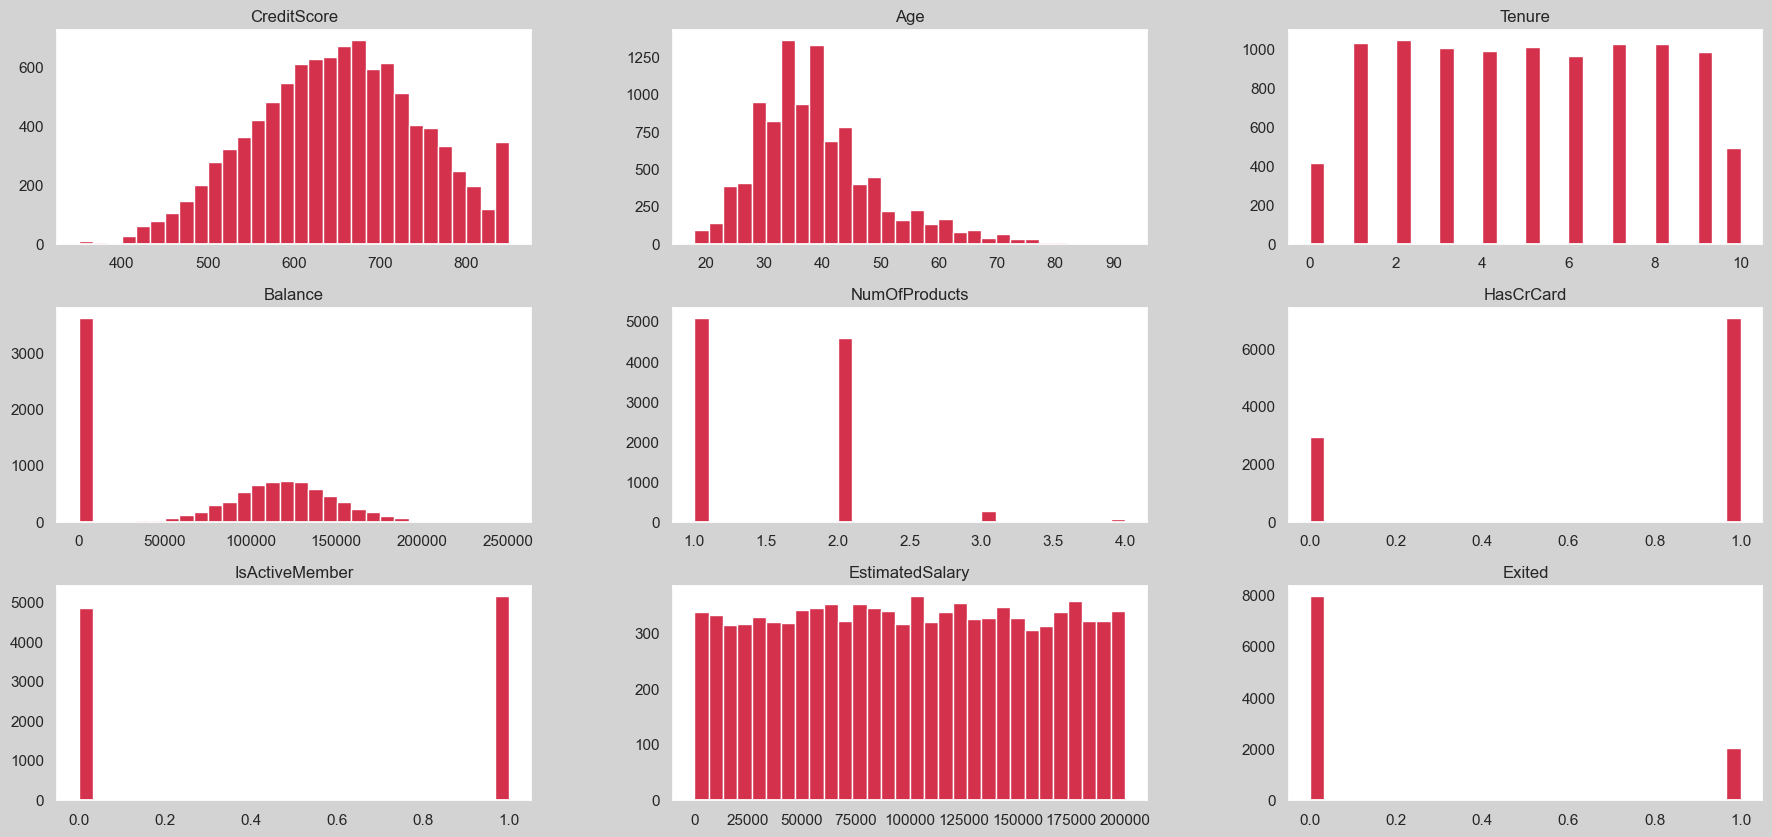

In [102]:
new_df.hist(bins = 30, figsize=(22, 10), color = '#D4314C');

Since this dataset is so large, it can be hard to tell exactly whether or not a distribution is normal. In order to proceed with my analysis, I will check for normality using the Anderson test.

I picked the Anderson test for the creditscore variable since more weight is given to the tails of the distribution. This is Useful in this situation because of the sharp uptick at the right-tail of 'CreditScore'. 

Additionally, the Anderson test is suitable for large sets of observations. The Shapiro-Wilk test for normality would probably determine the 'CreditScore' variable to be normally distributed, since it is an unsuitable test for large inputs.


In [103]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Suppress warning. 
    # The warning states the shapiro wilk test is inaccurate for N > 5000.
    # Current N is 10000
    stat, p = shapiro(X['CreditScore'])
    print(f"Shapiro-Wilk Test: Stat = {round(stat, 3)}, p-val = {p}\n")


result = anderson(X['CreditScore'])
print(f"Anderson Test: test-stat = {round(result.statistic, 3)}, Critical Values = {result.critical_values}")

Shapiro-Wilk Test: Stat = 0.994, p-val = 3.470965102195083e-20

Anderson Test: test-stat = 5.458, Critical Values = [0.576 0.656 0.787 0.918 1.092]


The Anderson test statistic is 5.458. The critical values [0.576 0.656 0.787 0.918 1.092] correspond to significance levels [15%, 10%, 5%, 2.5% 1%]. Since the test statistic is greater than all critical values, we reject the null hypothesis. 

Compare this to the Shapiro-Wilk test. Since its p-value is less than 0.05, we would reject the null hypothesis and determine that the data is normally distributed. However, since the Shapiro test is not suitable for this dataset, we will disregard it.

Therefore, the Anderson test determined that 'CreditScore' is not normally distributed.

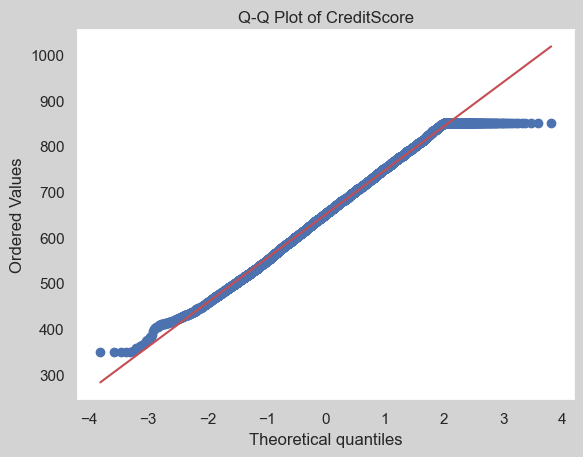

In [104]:
probplot(X['CreditScore'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of CreditScore")
plt.show()

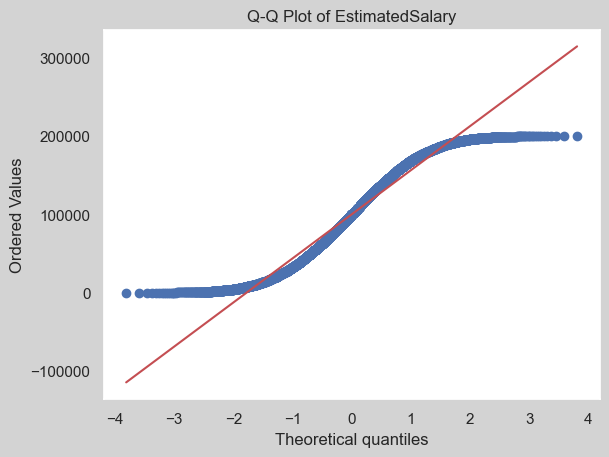

In [105]:
probplot(X['EstimatedSalary'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of EstimatedSalary")
plt.show()

When looking at the "CreditScore" Q-Q Plot, it is obviously not normally distributed. Also, I threw in the "EstimatedSalary" Q-Q plot. It follows a more uniform like distribution.

We can visually inspect the previously produced histograms to determine that the "Balance" variable will behave simalarly.


### Why use a neural network

Since the output variable is binary, we need a to use multiple logistic regression. Logistic regression does not require a normal distribution. However, it would require manual feature engineering to capture non-linear relationships, whereas a neural network is capable of automatically learning these patterns. This greatly cuts down on the amount of pre-processing work, since we only need to encode the categorical variables and scale all the features.

The non-linear nature of this data, non-normal distribution, as well as the mix of categorical and quantitative data suggests that a neural network is a good model to build.

# Building The Neural Network

## Label Encoding

Upon manual observation, the dataset is sufficiently shuffled. The observations are not sorted based on geography, balance, credit score, or any other variable. Therefore, we don't necessarily need to concern our selves with shuffling the dataset before building the model.

Since we have two categorical variables, we must encode them before proceeding with the analysis.

In [106]:
adjust_length = 17 # offset for output formatting

for col in X:
    print(f"{col.ljust(adjust_length)} : {X[col].dtypes}")
print(f"{("Exited").ljust(adjust_length)} : {Y['Exited'].dtypes}")

CreditScore       : int64
Geography         : object
Gender            : object
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Exited            : int64


The "Gender" variable will be encoded. A 0 represents the "Female" gender, a 1 represents the "Male" Gender.

Similarly, the "Geography" variable will be encoded. Each geographical location will recieve its own binary column, with a 1 occurring in the column where the observation is located.

In [107]:
Encoder = LabelEncoder()
X['Gender'] = Encoder.fit_transform(X.iloc[:, 2]).astype(int)

display((X.loc[:, 'CreditScore':'Gender']).iloc[0 : 5])


print(f"{str(X['Gender'].name)} : {X['Gender'].dtypes}")


,CreditScore,Geography,Gender
0,619,France,0
1,608,Spain,0
2,502,France,0
3,699,France,0
4,850,Spain,0


Gender : int64


Now, the "Gender" variable is represented as an integer.

Next, we must encode the "Geography" variable.

In [108]:
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)

# Cast geography variables to integers
for col in X.columns:
    if 'Geography_' in col :
        X[col] = X[col].astype('int64')

for col in X:
    print(f"{col.ljust(adjust_length)} : {X[col].dtypes}")

CreditScore       : int64
Gender            : int64
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Geography_Germany : int64
Geography_Spain   : int64


Now all of the variables are represented numerically.

In [109]:
fin_df = X.copy()
fin_df['Exited'] = Y

display(fin_df.iloc[0 : 5])

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0,0,1
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1,0


## Feature Scaling


Now that the categorical variables have been encoded, we will scale the features. This step esures that the range of features is standardized.

It is important that only the quantitative variables are scaled. Categorical variables are now represented as integers, and the scaler would scale them if we let it. This would destroy the categorical variables. 

To proceed, I will split the data into "quantitative_cols" and "categorical_cols". Only the quantitative data will be scaled, then the categorical data will be concatenated with the scaled quantitative data.

I will detail this step with additional comments, since I have made this mistake in the past, and I see it in other notebooks often.

In [110]:
# Separate data
quantitative_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
categorical_cols  = ["Gender", "HasCrCard", "IsActiveMember", "Geography_Germany", "Geography_Spain"]

# Create train / test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM)
scaler = StandardScaler()

# Scaler quantitative data
X_train_scaled_quan = pd.DataFrame(scaler.fit_transform(X_train[quantitative_cols]), columns = quantitative_cols, index=X_train.index)
X_test_scaled_quan  = pd.DataFrame(scaler.transform(X_test[quantitative_cols]), columns = [quantitative_cols], index = X_test.index)

# Concatenate scaled quantitative data with categorical data
X_train_scaled = pd.concat([X_train_scaled_quan, X_train[categorical_cols]], axis=1)
X_test_scaled  = pd.concat([X_test_scaled_quan, X_test[categorical_cols]], axis = 1)

# Reset the indicies in the pandas dataframe to start at 0
X_train_scaled.reset_index(drop = True, inplace=True)
X_test_scaled.reset_index(drop=True, inplace=True)

# Display scaled training data
display(X_train_scaled.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Gender,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain
0,0.874900,0.769571,1.718867,0.234984,0.803187,0.666325,0,1,1,1,0
1,1.622552,0.865338,-0.348425,1.406010,-0.915779,-1.369820,1,1,1,0,0
2,0.376466,-0.379632,-1.037522,0.520153,0.803187,-0.249320,1,0,1,1,0
3,-0.267345,0.290736,-0.692973,1.093228,-0.915779,-0.489941,1,1,0,0,0
4,-0.246577,-0.954233,-0.348425,0.462937,0.803187,-1.028741,0,0,0,0,0


Notice how the categorical data is preserved. Next, I will demonstrate what not to do, and why it is a bad idea.

In [111]:
do_NOT_do_this = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
display(do_NOT_do_this.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
4914,0.874900,-1.103868,0.769571,1.718867,0.234984,0.803187,0.649203,0.970923,0.666325,1.730320,-0.580237
1471,1.622552,0.905905,0.865338,-0.348425,1.406010,-0.915779,0.649203,0.970923,-1.369820,-0.577928,-0.580237
1455,0.376466,0.905905,-0.379632,-1.037522,0.520153,0.803187,-1.540351,0.970923,-0.249320,1.730320,-0.580237
8504,-0.267345,0.905905,0.290736,-0.692973,1.093228,-0.915779,0.649203,-1.029948,-0.489941,-0.577928,-0.580237
5140,-0.246577,-1.103868,-0.954233,-0.348425,0.462937,0.803187,-1.540351,-1.029948,-1.028741,-0.577928,-0.580237


The StandardScaler standardizes all numeric columns by subtracting the mean and dividing by the standard deviation, transforming the binary variables into continuous values. This destroys the meaning of the categorical data. 

For example, look at the gender column in the "do_NOT_do_this" dataframe. -1.103 gender is meaningless, and it should NOT be compared to an observation with 0.0905 gender. An ML model will intrepret scaled values as having a numerical relationship, and it would compare -1.103 gender to 0.095 gender.

Scaling categorical variables introdices noise and misrepresents the meaning of the original dataset. It confuses the model and leads to less meaningful results. Potentially, it will lead to an over-optimistic model.

## Correlation Analysis

## Building the Neural Network

## Optimizing the Model

# Analyze Model

# Conclusions


to-do: 

       - Perform basic EDA BEFORE encoding / scaling
       - Scale features
       - Perform EDA AFTER encoding/scaling
       - Build neural network
       - Optimize NN
       - Analyze NN accuracy
       - Review + Document
       - Publish

